In [1]:
import networkx as nx
import osmnx as ox

In [2]:
# Dodaje odpowiednie tagi do filtrów - w osmnx jest używany Overpas QL, można tworzyć też customowe filtry
ox.settings.useful_tags_way+=['cycleway', 'surface']
ox.settings.useful_tags_way

['bridge',
 'tunnel',
 'oneway',
 'lanes',
 'ref',
 'name',
 'highway',
 'maxspeed',
 'service',
 'access',
 'area',
 'landuse',
 'width',
 'est_width',
 'junction',
 'cycleway',
 'surface']

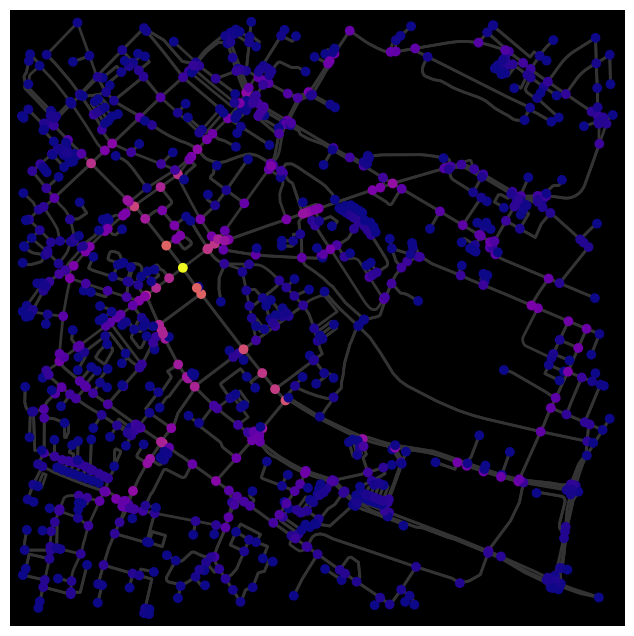

In [3]:
import networkx as nx
import osmnx as ox
useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name',
                    'highway', 'maxspeed', 'service', 'access', 'area',
                    'landuse', 'width', 'est_width', 'junction', 'surface']
# ox.utils.config(useful_tags_path=useful_tags_path) # deprecatedd

# # useful_tags = ox.settings.useful_tags_path + ['cycleway']
# ox.useful_tags_way = ox.settings.useful_tags_way + ['cycleway', 'surface']
# ox.settings.useful_tags_path = ox.settings.useful_tags_way + ['bicycle', 'surface']

# download street network data from OSM and construct a MultiDiGraph model
# 50.291100737108025, 18.680043199195698 - RMS
G = ox.graph.graph_from_point((50.291100737108025, 18.680043199195698), dist=1000, network_type="bike")


# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)
# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames

# gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
# G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="length")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="length", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# # save graph as a geopackage or graphml file
# ox.io.save_graph_geopackage(G, filepath="./graph.gpkg")
# ox.io.save_graphml(G, filepath="./graph.graphml")

In [4]:
# Tworzy projekcje z CRS do normalnego UTM - TODO: trzeba doczytać
G = ox.project_graph(G, to_latlong=True)

In [5]:
# Lista rodzajów nawierzchni w grafie
edges = ox.graph_to_gdfs(G, nodes=False)
edges["surface"].explode().unique()

array(['asphalt', nan, 'paved', 'paving_stones', 'sett', 'compacted',
       'dirt', 'unpaved', 'ground', 'cobblestone', 'wood', 'fine_gravel',
       'gravel', 'grass_paver', 'concrete', 'unhewn_cobblestone'],
      dtype=object)

In [6]:
edges.head()

osmid lanes                   name   highway  \
u         v          key                                                     
27475388  965120926  0    104866412     2              Bojkowska  tertiary   
          900922189  0    104866449     2              Bojkowska  tertiary   
965120926 965120943  0     82948362   NaN  Ratowników Górniczych   service   
          27475388   0    104866412     2              Bojkowska  tertiary   
900922189 3217900888 0    104866449     2              Bojkowska  tertiary   

                         maxspeed  surface  oneway reversed  length  \
u         v          key                                              
27475388  965120926  0         50  asphalt   False    False  47.580   
          900922189  0         50  asphalt   False     True  45.089   
965120926 965120943  0        NaN      NaN   False    False  71.298   
          27475388   0         50  asphalt   False     True  47.580   
900922189 3217900888 0         50  asphalt   False     True  39.035   

                                                                   geometry  \
u         v          key                                                      
27475388  965120926  0    LINESTRING (18.67609 50.28284, 18.67628 50.282...   
          900922189  0    LINESTRING (18.67609 50.28284, 18.67590 50.283...   
965120926 965120943  0    LINESTRING (18.67645 50.28248, 18.67650 50.282...   
          27475388   0    LINESTRING (18.67645 50.28248, 18.67635 50.282...   
900922189 3217900888 0    LINESTRING (18.67574 50.28318, 18.67544 50.28348)   

                          speed_kph  travel_time junction  ref cycleway  \
u         v          key                                                  
27475388  965120926  0         50.0          3.4      NaN  NaN      NaN   
          900922189  0         50.0          3.2      NaN  NaN      NaN   
965120926 965120943  0         26.6          9.6      NaN  NaN      NaN   
          27475388   0         50.0          3.4      NaN  NaN      NaN   
900922189 3217900888 0         50.0          2.8      NaN  NaN      NaN   

                         tunnel service access bridge width  
u         v          key                                     
27475388  965120926  0      NaN     NaN    NaN    NaN   NaN  
          900922189  0      NaN     NaN    NaN    NaN   NaN  
965120926 965120943  0      NaN     NaN    NaN    NaN   NaN  
          27475388   0      NaN     NaN    NaN    NaN   NaN  
900922189 3217900888 0      NaN     NaN    NaN    NaN   NaN

In [7]:
import matplotlib.pyplot as plt

# Tworzenie kolorowania dla krawędzi o różnych nawierzchniach
surface_mapping = {v: k for k, v in enumerate(edges["surface"].explode().unique())}
cmap_type = plt.get_cmap('Set3')

edge_coloring = []
for u, v, att in G.edges(data=True):
    if  "surface" in att:
        if isinstance(att["surface"], list):
            surf = att["surface"][0]
            r,g,b,a = cmap_type(surface_mapping[surf])
        else:
            surf = att["surface"]
            r,g,b,a = cmap_type(surface_mapping[surf])
    else:
        r,g,b,a = cmap_type(-1)
        # (u, v, 0) -> key
    edge_coloring.append([r, g, b, 0.3*a]) # 0.3 żeby nie były tak jasne

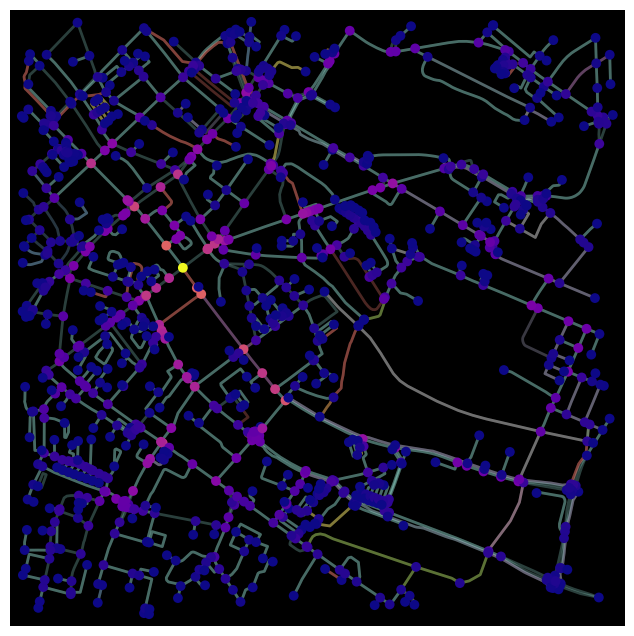

In [8]:
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color=edge_coloring
)

# Dodanie wag związanych z rodzajem trasy

In [9]:
# Dodanie funckje wagi, która zwraca daną wartości zależnie od tego, czy droga jest asfaltowa lub inna
# Na razie roboczo tylko tak dla testów - będzie można się tym pobawić i przede wszystkim uzależnić od preferencji użytkownika. Również wziąć różne typy tras pod uwagę
# Jeśli chodzi o wartości liczbowe to +/-, żeby jakoś działało
def weight_func(u, v, d):
    key = 0 # TODO: zobaczyc czy key moze byc inny niz 0
    if "surface" in d.keys():
        if d[key]["surface"]=="asphalt":
            return 100
    return 0

In [10]:
# Funkcja dystansu, tutaj z uzwględnieniem krzywizny ziemi
def dist(a, b):
    re = ox.distance.great_circle(lat1=G.nodes[a]['y'],
                             lon1=G.nodes[a]['x'],
                             lat2=G.nodes[b]['y'],
                             lon2=G.nodes[b]['x']
                             )
    return re

### Poniżej zaprezentowana jest różnica w działaniu A* z wagami i wybraną heurystyką, a bez niech (waga jako długość krawędzi) 

In [11]:
# Losowy punkt startowy (tutaj kochany RMS) 50.291100737108025, 18.680043199195698
a = ox.nearest_nodes(G, Y=50.291100737108025, X=18.680043199195698)
# Drugi jakiś randomowy 50.29407909135578, 18.666791202052075
b = ox.nearest_nodes(G, Y=50.29407909135578, X=18.666791202052075)

In [12]:
# Dystanse
for id, value in G.nodes(data=True):
    print(dist(a,id))

923.4062881895104
954.7832296441784
895.547194973102
640.3946382203641
642.5914914319427
633.157970877939
706.7587938542939
735.1526939422793
699.1577900326154
840.6210053260208
1037.2363479267049
1002.9498501709434
1027.5263160112902
862.672030912174
820.5985152432771
862.2672962836423
873.0971386231777
867.3437708474212
865.67723180861
848.3995217836124
809.7026584530686
741.0592662639236
671.8898347927285
776.5228313241724
682.6124505194924
914.2573049661827
908.0544643308814
487.2383995547035
447.75170325475017
571.0667936179472
418.0519808275523
440.1853466909892
421.476791061857
441.50020633696136
464.15094258354816
404.5112983621673
611.9860375667967
614.8788573940514
509.99824549720347
617.7297980806555
431.829906870244
415.17595015389287
489.04559150279795
422.12146532087604
423.54878904797033
481.41237676336954
409.1821468510907
840.3432776931035
784.0575281503178
846.6795033663471
597.4546508737859
580.2695554794416
837.4704447547662
861.1939437222817
555.3667985459359
555.0

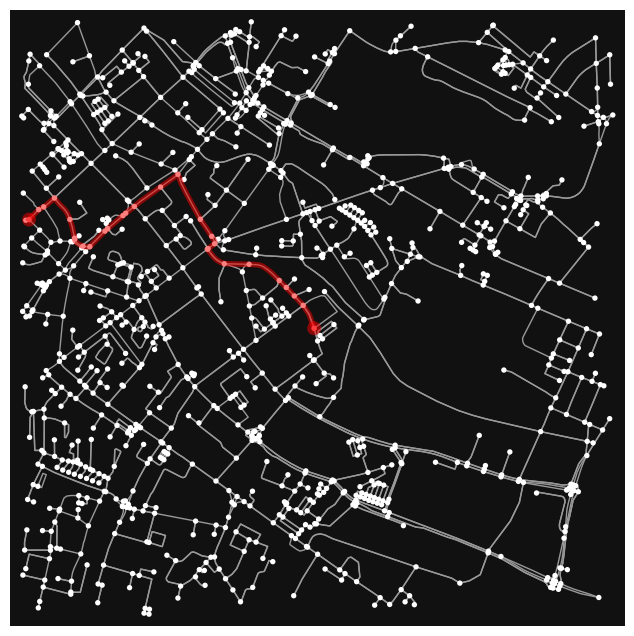

In [13]:
path = nx.astar_path(G, a, b, heuristic=dist ,weight=weight_func)
fig, ax = ox.plot_graph_route(G, path)

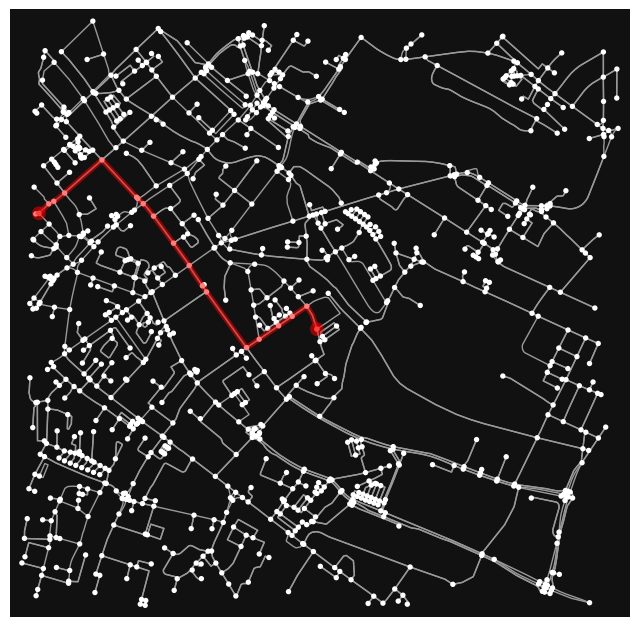

In [29]:
path = nx.astar_path(G, a, b, heuristic=dist, weight="length")
fig, ax = ox.plot_graph_route(G, path)

# Algorytm

In [15]:
# def makeRoute(start, distance):
#     # Going out
#     err = 10
#     path = []
#     part = distance/4
#     a = start
#     b = start
#     for id, vals in G.nodes(data=True):
#         d = dist(a,id)
#         if part-err<d<part+err:
#             b = id
#             break
#     path+=nx.astar_path(G, a, b, heuristic=dist ,weight=weight_func)

#     a = b
#     for id, vals in G.nodes(data=True):
#         d = dist(a,id)
#         d_from_start = dist(start,id)
#         if part-err<d<part+err and part<d_from_start<part*2:
#             b = id
#             break
#     path+=nx.astar_path(G, a, b, heuristic=dist ,weight=weight_func)[1:]

#     a = b
#     # Oh fuck go back
#     path+=nx.astar_path(G, a, start, heuristic=dist ,weight=weight_func)[1:]

#     print(path)
#     return path

# Algorytm na razie bardzo roboczo, byleby cokolwiek działało.
# Dystans dzielimy na 4
# I krok: uciekamy o 1/4 trasy
# II krok: uciekamy od nowego punktu, ale nie za daleko od poczatku
# III krok: wracamy astarem do domu (po połowie trasy)
# W tej chwili bierze tylko odległośc pod uwage, jako odległośc od początku - jak już na tym etapie wygląda git to super xD
# TODO: Rozwinąć
def makeRoute(start, distance, dist_func = dist):
    # Going out
    err = 10
    path = []
    part = distance/4
    a = start
    b = start
    for id, vals in G.nodes(data=True):
        d = dist_func(a,id)
        if part-err<d<part+err:
            b = id
            break
    path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func)

    a = b
    for id, vals in G.nodes(data=True):
        d = dist_func(a,id)
        d_from_start = dist_func(start,id)
        if part-err<d<part+err and part<d_from_start<part*2:
            b = id
            break
    path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func)[1:]

    a = b
    # Oh no! go back
    path+=nx.astar_path(G, a, start, heuristic=dist_func ,weight=weight_func)[1:]

    print(path)
    return path

In [16]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

[264864144, 264864141, 1021364360, 1021364253, 900922138, 262832462, 264864145, 264864149, 2896549793, 29018449, 610299257, 262830042, 262639795, 1969556143, 29103943, 2213116224, 606717147, 6522294761, 606717140, 332312981, 606640906, 29076336, 29018670, 8726008882, 2449926626, 2449926584, 29018671, 2449926588, 29402527, 900922307, 2480216725, 2480216712, 262832464, 10875759352, 10875759356, 264864141, 264864144]


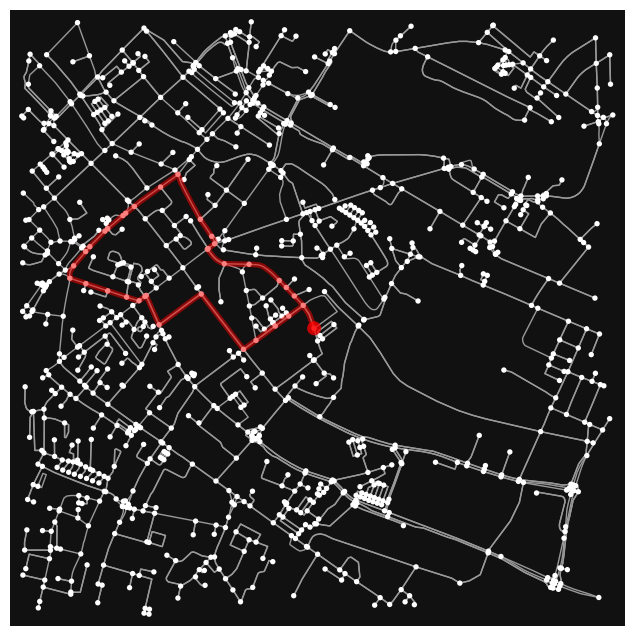

[264864144, 262832457, 10876307308, 1021004559, 262831991, 2480216704, 2480216712, 1020810757, 1713269477, 29402529, 634451683, 634451681, 28895552, 357140178, 28895552, 634451681, 2641038252, 7967992010, 2641038268, 29015377, 2496833019, 2448166834, 29428609, 31729684, 2449926445, 11148966242, 2448195950, 29018671, 2449926588, 29402527, 1803084601, 3561365741, 29018448, 1952422062, 1969556124, 29103943, 2213116224, 606717147, 6522294761, 606717140, 332312981, 606640906, 29076336, 29018670, 8726008882, 2449926626, 2449926584, 29018671, 2449926588, 29402527, 900922307, 2480216725, 2480216712, 262832464, 10875759352, 10875759356, 264864141, 264864144]


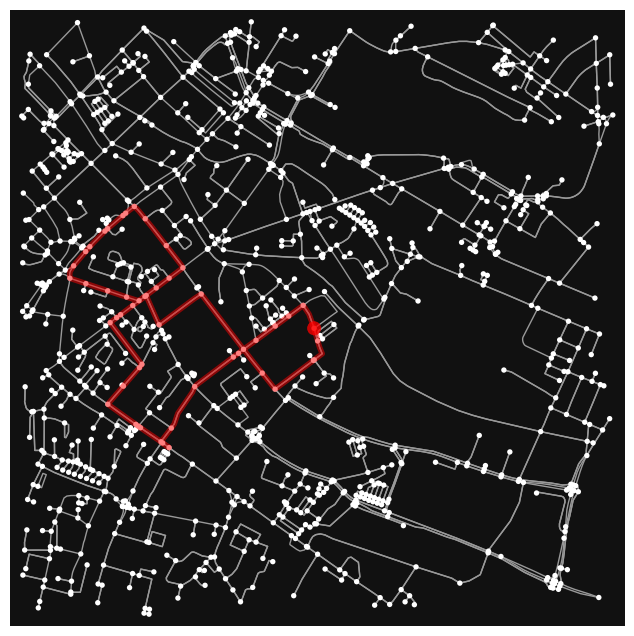

[264864144, 264864141, 10875759356, 10875759352, 262832464, 2480216712, 1020810757, 1713269477, 29402529, 634451683, 7967992003, 7967992010, 2641038268, 29015377, 2641038268, 2641038238, 2641038252, 634451681, 28895552, 357140176, 2709068814, 628087894, 628087875, 628087877, 628087868, 2055857914, 628087858, 36729899, 1158754759, 36729898, 9450944128, 9450944130, 28895553, 611590807, 3217900888, 900922189, 27475388, 900922189, 3217900888, 611590807, 28895553, 611597522, 2133755558, 611597548, 611597557, 29018496, 2709068821, 29018497, 632380953, 5005986266, 632380947, 2055785588, 632380971, 632409305, 262831991, 1021004559, 10876307308, 262832457, 264864144]


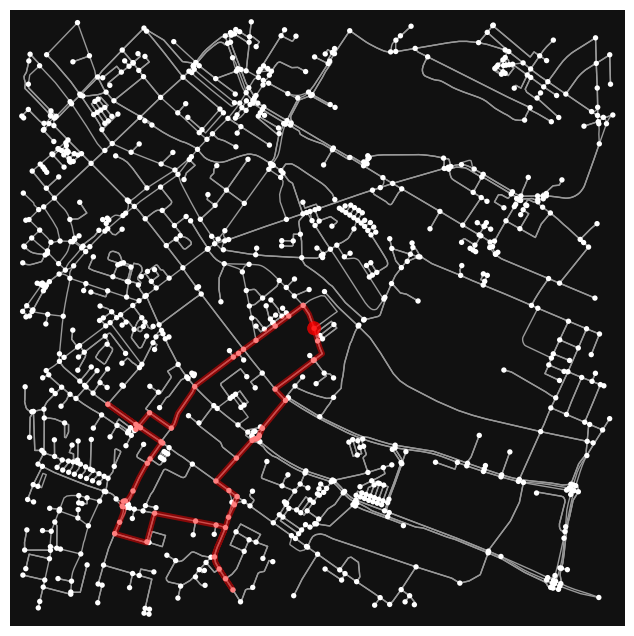

In [17]:
path = makeRoute(a, 1500)
fig, ax = ox.plot_graph_route(G, path)
path = makeRoute(a, 2500)
fig, ax = ox.plot_graph_route(G, path)
path = makeRoute(a, 3000)
fig, ax = ox.plot_graph_route(G, path)

### Na innych funkcjach wag i kosztu

In [18]:
def dist2(a, b):
    re = ox.distance.euclidean(y1=G.nodes[a]['y'],
                             x1=G.nodes[a]['x'],
                             y2=G.nodes[b]['y'],
                             x2=G.nodes[b]['x']
                             )
    return re

In [19]:
def weight_func(u, v, d):
    key = 0
    if "surface" in d.keys():
        if d[key]["surface"]=="asphalt":
    #         return 100
    # return 50

    # Euclidean zwraca w innych jednostkach niż ten wielki krąg
                return 0.001
    return 0

In [20]:
# Inna jednostka
for id, value in G.nodes(data=True):
    print(dist2(a,id))

0.00881769357711891
0.008997208467072727
0.008678865668396192
0.007982255200756601
0.008040893632548842
0.007775032116334073
0.008731918156395232
0.007361308579322102
0.007021245875911659
0.008388637408420349
0.013732033629802737
0.01336436400768929
0.01355682283022117
0.010302337876908168
0.009907885096223422
0.010374424788394013
0.010412379670851681
0.010297261640844265
0.012125538147644577
0.011895088493155005
0.011233119791492047
0.010055594039637813
0.009218640771828367
0.010671055683953367
0.008945292521209925
0.012776261991679968
0.012668708727412804
0.006493313331419219
0.005603198758746449
0.007450120469496735
0.005697247708324015
0.005372539031968646
0.005000519045060783
0.005295238431835126
0.005604764865720751
0.004919864097715543
0.0065671415981362205
0.007094504746636445
0.005393231461752441
0.006366801196833579
0.00449600748442627
0.004450176689751867
0.004410792729204025
0.0043634861349602285
0.004293280248250816
0.004339912640823168
0.004193490170489056
0.0116873525304

In [21]:
def makeRoute(start, distance, dist_func = dist):
    # Going out
    err = 0.001
    path = []
    part = distance/4
    a = start
    b = start
    for id, vals in G.nodes(data=True):
        d = dist_func(a,id)
        if part-err<d<part+err:
            b = id
            break
    path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func)

    a = b
    for id, vals in G.nodes(data=True):
        d = dist_func(a,id)
        d_from_start = dist_func(start,id)
        if part-err<d<part+err and part<d_from_start<part*2:
            b = id
            break
    path+=nx.astar_path(G, a, b, heuristic=dist_func ,weight=weight_func)[1:]

    a = b
    # Oh no! go back
    path+=nx.astar_path(G, a, start, heuristic=dist_func ,weight=weight_func)[1:]

    print(path)
    return path

[264864144, 264864141, 10875759356, 10875759352, 262832464, 2480216712, 2480216725, 900922307, 29428610, 2448195758, 3525829441, 29428609, 2448166834, 2496833019, 29015377, 976244273, 29428601, 29428599, 2390545800, 29428598, 2708844022, 628824724, 628824731, 29428595, 628824731, 628824724, 2708844022, 29428598, 2708844338, 29017191, 29015376, 634439571, 2449926350, 2448167002, 2449926402, 31729684, 2449926445, 11148966242, 2448195950, 29018671, 2449926588, 29402527, 1803084601, 3561365741, 29018448, 1952422062, 1969556124, 29103943, 262830039, 3907002778, 29104023, 5325836463, 1947396931, 1947295075, 4695741280, 29403439, 1690389849, 1690389850, 288601683, 1690389850, 1690389849, 8794529937, 8794529930, 610239434, 1361900011, 7865036436, 1361900085, 3878749030, 10572932287, 6598747400, 10858347611, 1021168198, 1021168065, 2040437211, 610299260, 1952219115, 610299258, 610299257, 262830042, 262639795, 1969556143, 1969556134, 1969556117, 3850414598, 3850414588, 1952422062, 29018448, 2648

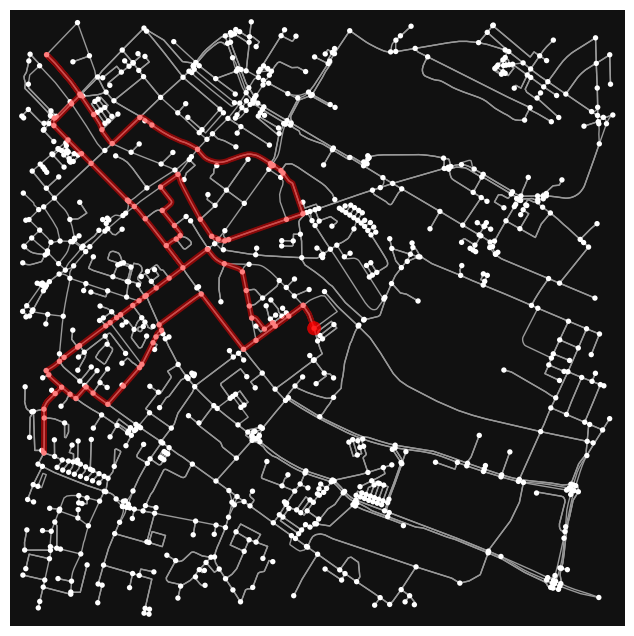

In [22]:
path = makeRoute(a, 0.05, dist_func=dist2)
fig, ax = ox.plot_graph_route(G, path)

# Other bullshit (moze się potem przydać do prezentacji idk)

In [23]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(G,x[0],y[0])
G = ox.project_graph(G)

In [24]:
# place = 'Berkeley, CA, USA'
# network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [25]:
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [26]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

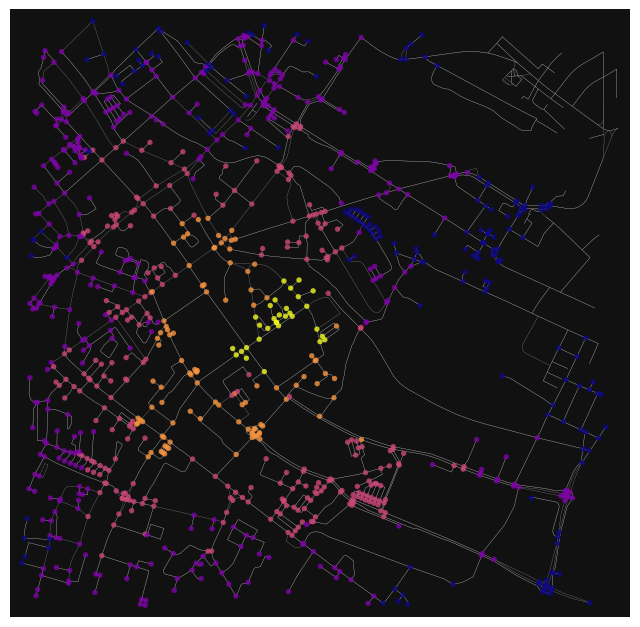

In [27]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')